In [1]:
import h5py
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
path_qcd  = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_backgroundMC_Pythia.h5'
path_sig  = '/home/waleed/Desktop/LHC-Olympics/events_anomalydetection.h5'
path_data = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_BlackBox1.h5'

In [3]:
def read_file(path='', nevts=1e4):
    f = pd.read_hdf(path,stop=nevts)
    
    # change naming convention of the coulmns
    old = list(f.columns)
    new = ['pt','eta','phi']
    new = [new]*700
    new = [item for sublist in new for item in sublist]
    dictionary = dict(zip(old, new))
    df = f.rename(dictionary, axis=1)
    
    return df

def get_hadrons(df=None, signal=False, trim=True):
    y=None
    if signal:
        y = df.iloc[:,-1]   
        df = df.drop([2100], axis=1)
    
    data    = np.array(df)
    hadrons = []
    for idx in tqdm(range(data.shape[0])):
        l = np.array(np.split(data[idx], 700))
        hadrons.append(l)
    
    hadrons = np.vstack(hadrons)
    
    
    if trim:
        hadrons = hadrons[~np.all(hadrons == 0., axis=1)]    
    
    hadrons = pd.DataFrame(hadrons, columns=['pt','eta','phi'])
    
    if signal:
        hadrons['label'] = y
    
    return hadrons

In [4]:
df = read_file(path_sig, 1e3)

In [5]:
df.shape

(1000, 2101)

In [6]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # my CUDA is out of memory
device = 'cpu'

In [7]:
class MyDataset(Dataset):
    '''
    Create Classification Dataset.
    Model dependent  W'->XY events, with X->jj and Y->jj
    The W', X, and Y masses are 3.5 TeV, 500 GeV and 100 GeV respectively
    '''

    def __init__(self, inputs=None, transform=None):
        '''
        Args:
            inputs    (pandas): Input Dataframe
            transform (str)   : Data Standarization/Normalization or None
        '''
        self.__inputs__    = inputs
        self.__transform__ = transform
        
        self.__X__, self.__y__ = self.transform()
    
    def transform(self):
        
        X_train, _ , y_train, _ = train_test_split(self.__inputs__.iloc[:,0:-1], \
                                                   self.__inputs__.iloc[:,-1], test_size = 0.005, random_state=0)

        X_train    = np.array(X_train)
        
        train_data = []
        for idx in tqdm(range(X_train.shape[0])):
            l = np.array(np.split(X_train[idx], 700))
            train_data.append(l)        
        
        if self.__transform__== 'standarize':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
        
        elif self.__transform__== 'normalize':
            scale = np.array([1000.,1.,1.])
            scale = np.tile(scale, 700)
            X_train = X_train/scale
        
        elif self.__transform__== None:
            print ('No Data manipulation is performed.')
            pass
        
        else:
            raise ValueError('options avaliable are \'standarize\', \'normalize\', or \'None\' ')
            
        
        return np.array(train_data), np.array(y_train)
            
            
    def __len__(self):
        return len(self.__X__)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.__X__[idx]), torch.Tensor([self.__y__[idx]])
    
    def getX(self):
        return self.__X__
    
    def gety(self):
        return self.__y__    

In [8]:
dataset = MyDataset(inputs=df, transform='standarize')

100%|██████████| 995/995 [00:01<00:00, 984.11it/s]


In [9]:
batch_size = int(0.5*1024)

In [10]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [11]:
# build the model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dp  = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        # Apply sigmoid activation (binary classification)
        out = torch.sigmoid(out)
        return out

In [12]:
in_features   = 3
hidden_size   = 64
nb_rnn_layers = 2
nb_classes    = 1
net = RNN(in_features, hidden_size, nb_rnn_layers, nb_classes).to(device)   
print (net)

RNN(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dp): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [13]:
# create an Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [14]:
# Train the model
total_step = len(dataloader)
kEpochs = 5
acc = []
for epoch in range(kEpochs):
    correct = 0
    total = 0    
    for i_batch, (inputs, labels) in enumerate(dataloader):
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device).reshape(batch_size, 1)       
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        labels = labels.view(-1)
        total += labels.size(0)        
        predicted = torch.round(outputs).view(-1)
        correct += (predicted == labels).sum().item()        
        if (i_batch+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} | Accuracy: {:.4f}' 
                   .format(epoch+1, kEpochs, i_batch+1, total_step, loss.item(), ((predicted == labels).sum().item()/labels.size(0))))
    acc.append((correct/total))
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} | Accuracy: {:.4f}'\
           .format(epoch+1, kEpochs, i_batch+1, total_step, loss.item(), (correct/total)))    

Epoch [1/5], Step [1/1], Loss: 0.7066 | Accuracy: 0.0957
Epoch [1/5], Step [1/1], Loss: 0.7066 | Accuracy: 0.0957
Epoch [2/5], Step [1/1], Loss: 0.6958 | Accuracy: 0.0898
Epoch [2/5], Step [1/1], Loss: 0.6958 | Accuracy: 0.0898
Epoch [3/5], Step [1/1], Loss: 0.6851 | Accuracy: 0.9121
Epoch [3/5], Step [1/1], Loss: 0.6851 | Accuracy: 0.9121
Epoch [4/5], Step [1/1], Loss: 0.6747 | Accuracy: 0.9062
Epoch [4/5], Step [1/1], Loss: 0.6747 | Accuracy: 0.9062
Epoch [5/5], Step [1/1], Loss: 0.6639 | Accuracy: 0.9102
Epoch [5/5], Step [1/1], Loss: 0.6639 | Accuracy: 0.9102


In [15]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        predicted = torch.round(outputs).view(-1)
        labels = labels.view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f} %'.format(100 * correct / total))

Accuracy: 90.62 %


<IPython.core.display.Javascript object>


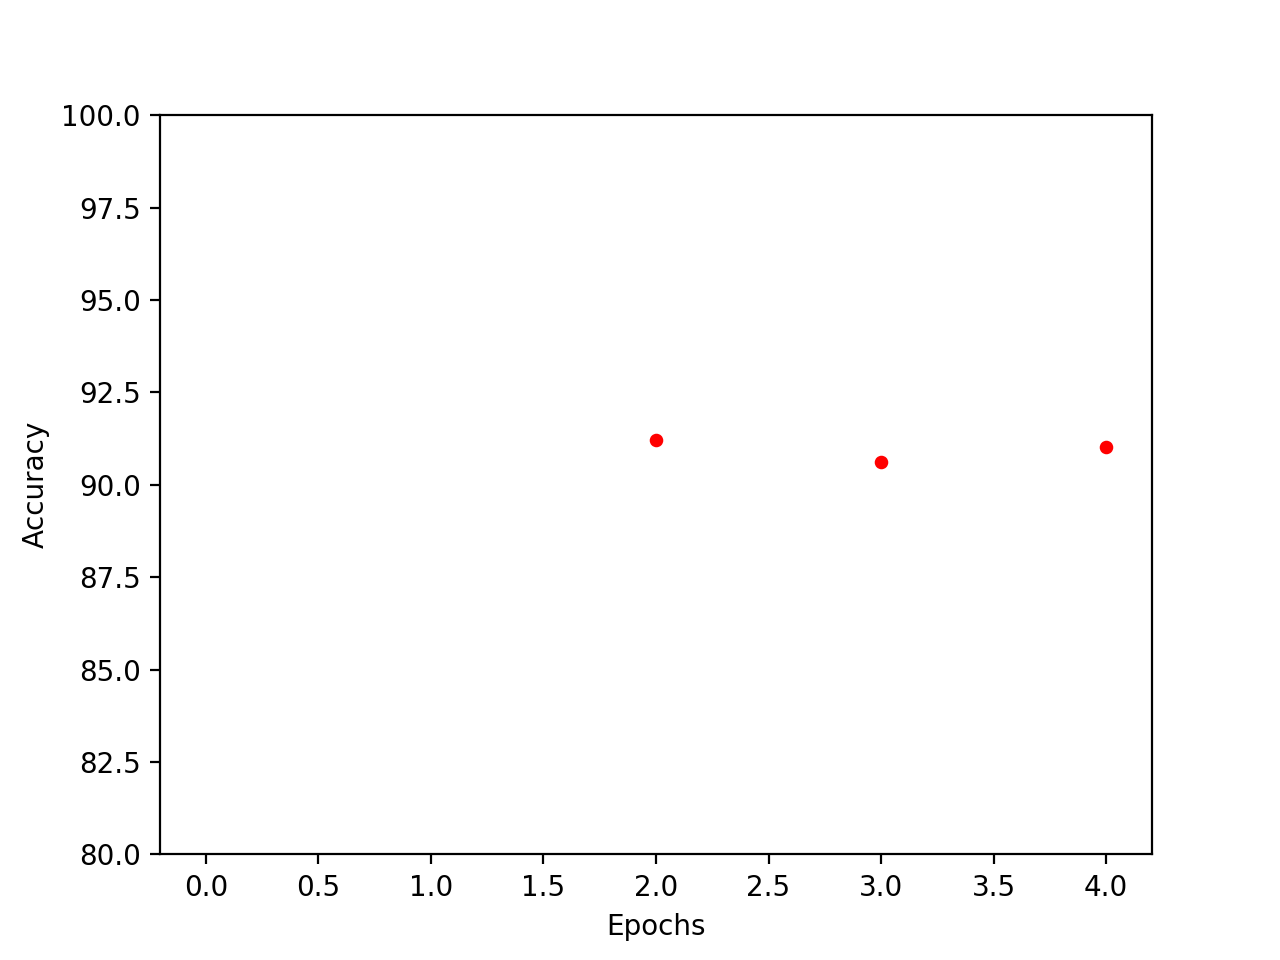

(80, 100)

In [16]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(np.arange(kEpochs), np.array(acc)*100, s=15, color='r')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.ylim(80,100)

In [17]:
# test on qcd background
df = read_file(path_qcd, 1e3)
df['label']=np.zeros(df.shape[0])

In [18]:
batch_size = int(0.5*1024)
dataset = MyDataset(inputs=df, transform='standarize')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

100%|██████████| 995/995 [00:01<00:00, 930.39it/s]


In [19]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        #print (outputs)
        #print (labels)
        predicted = torch.round(outputs).view(-1)
        #print (predicted)
        labels = labels.view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f} %'.format(100 * correct / total))

Accuracy: 100.00 %
